### INVASE

Pytorch Lightning implementation of INVASE. I think it has potential, but I don't have time to try it, so I'll share the notebook.

- [Original Paper](https://openreview.net/forum?id=BJg_roAcK7)
- [github](https://github.com/jsyoon0823/INVASE)

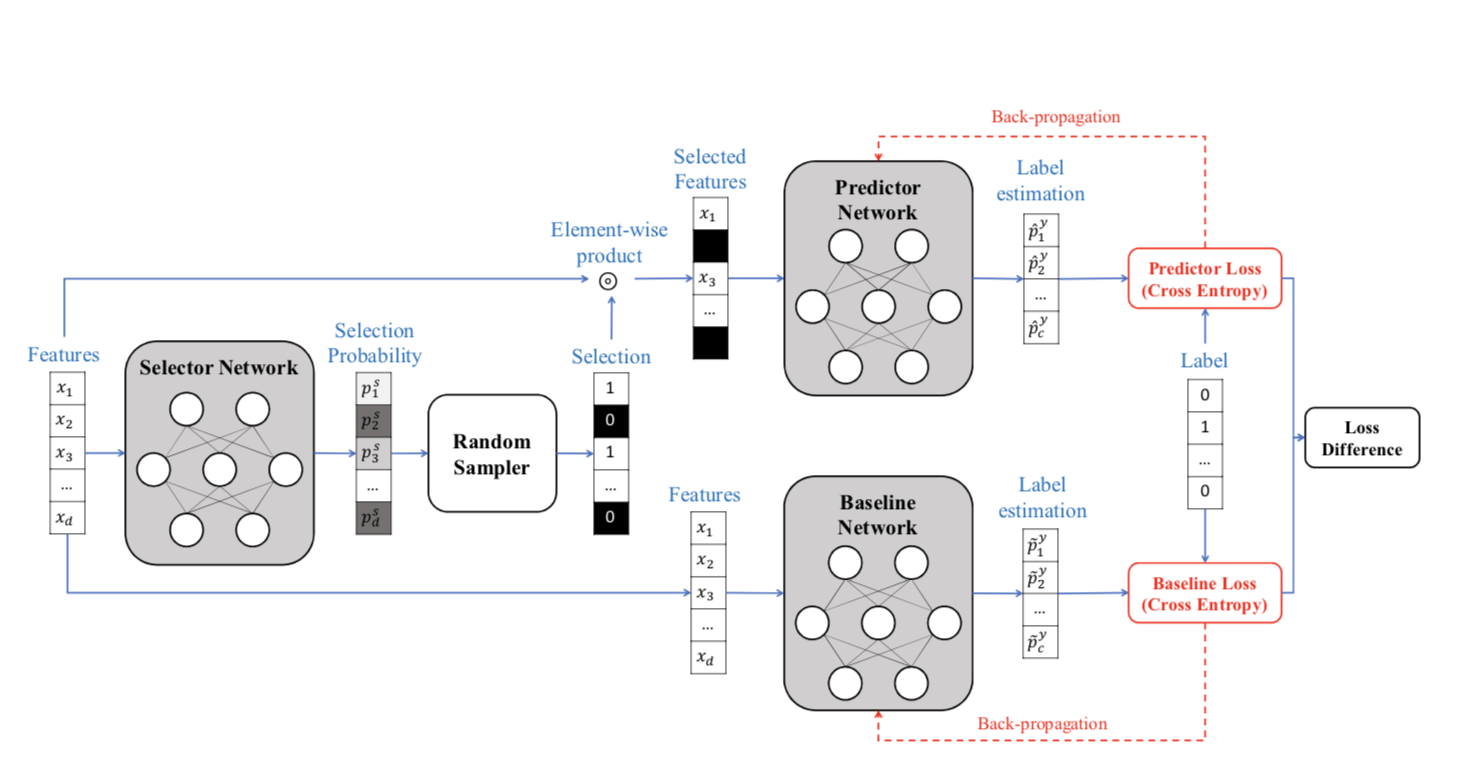

### Model

In [ ]:
from argparse import ArgumentParser
from pytorch_lightning.metrics import functional as FM

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F


def auc_multi(y_true, y_pred, exclude_index=None):
    M = y_true.shape[1]
    results = torch.zeros(M)
    sample_weight = None
    if exclude_index is not None:
        sample_weight = torch.ones(y_true.shape[0]).type_as(y_pred)
        sample_weight[exclude_index] = 0.0
    for i in range(M):
        try:
            results[i] = FM.auroc(
                y_pred[:, i], y_true[:, i], sample_weight=sample_weight
            )
        except:
            pass
    return results.mean()


def get_activation(activation):
    if activation == "relu":
        return nn.ReLU()
    elif activation == "leaky_relu":
        return nn.LeakyReLU()
    else:
        raise ValueError


class InvaseModel(pl.LightningModule):
    enable_print_log = True
    
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--learning_rate", type=float, default=0.0002)
        parser.add_argument("--max_learning_rate", type=float, default=None)
        parser.add_argument("--vehicle_weight", type=float, default=0.1)
        parser.add_argument("--num_layers", type=int, default=3)
        parser.add_argument("--actor_h_dim", type=int, default=100)
        parser.add_argument("--critic_h_dim", type=int, default=200)
        parser.add_argument("--weight_decay", type=float, default=1e-5)
        parser.add_argument("--lambda_", type=float, default=0.1)
        parser.add_argument("--minus", action="store_true")
        parser.add_argument("--scheduler_patience", type=int, default=10)
        parser.add_argument("--activation", type=str, default="relu")
        parser.add_argument("--dropout", type=float, default=0.2)
        return parser

    def __init__(self,
             learning_rate,
             input_dim: int = 874,
             output_dim: int = 206,
             include_vehicle: bool = False,
             vehicle_weight: float = 1.0,
             minus: bool = False,
             scheduler_patience: int = 10,
             class_weight=None,
             weight_decay: float = 1e-5,
             actor_h_dim: int = 100,
             critic_h_dim: int = 200,
             num_layers: int = 3,
             activation: str = "relu",
             dropout: float = 0.2,
             lambda_: float = 0.1,
            **kwargs,
        ):
        super(InvaseModel, self).__init__()
        self.class_weight = class_weight
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.include_vehicle = include_vehicle
        self.vehicle_weight = vehicle_weight
        self.weight_decay = weight_decay
        self.minus = minus
        self.scheduler_patience = scheduler_patience
        self.lambda_ = lambda_
        self._last_train_loss = None
        self.actor = self.build_layers(input_dim, actor_h_dim, input_dim,
                                       num_layers - 2, activation, dropout)
        self.critic = self.build_layers(input_dim, critic_h_dim, output_dim,
                                        num_layers - 2, activation, dropout)
        self._cache = None
        if self.minus:
            self.baseline = None
        else:
            self.baseline = self.build_layers(input_dim, critic_h_dim, output_dim,
                                              num_layers - 2, activation, dropout)
        self.save_hyperparameters()

    def build_layers(self, input_dim: int, hidden_dim: int, output_dim: int, n_layer: int,
                     activation: str,
                     dropout: float):
        layers = [
            nn.BatchNorm1d(input_dim),
            nn.Dropout(dropout),
            nn.utils.weight_norm(nn.Linear(input_dim, hidden_dim)),
            get_activation(activation),
        ]
        for i in range(n_layer):
            layers += [
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout),
                nn.utils.weight_norm(nn.Linear(hidden_dim, hidden_dim)),
                get_activation(activation),
            ]
        layers += [
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.utils.weight_norm(nn.Linear(hidden_dim, output_dim))
        ]
        return nn.Sequential(*layers)

    def actor_loss(self, selection, actor_out, baseline_loss, critic_loss, y):
        if self.minus:
            reward = - critic_loss
        else:
            reward = -(critic_loss - baseline_loss)
        y_pred = actor_out.sigmoid()
        actor_loss = selection * torch.log(y_pred + 1e-8) + (1 - selection) * torch.log(1 - y_pred + 1e-8)
        actor_loss = reward * actor_loss.sum(1) - self.lambda_ * y_pred.mean(1)
        return (-actor_loss).mean()

    def _train_loss(self, out, x, y):
        return F.binary_cross_entropy_with_logits(out, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        x = batch["x"].float()
        y = batch["y"].float()
        selection, actor_out, baseline_out, critic_out = self(x)
        if optimizer_idx == 0:
            critic_loss = self._train_loss(critic_out, x, y)
            self.log("train_critic_loss", critic_loss, logger=True, prog_bar=True)
            return critic_loss
        elif self.minus:
            if optimizer_idx == 1:
                critic_loss = self._train_loss(critic_out, x, y)
                actor_loss = self.actor_loss(selection, actor_out,
                                             None, critic_loss.detach(), y)
                self.log("train_actor_loss", actor_loss, logger=True, prog_bar=True)
                return actor_loss
        else:
            if optimizer_idx == 1:
                baseline_loss = self._train_loss(baseline_out, x, y)
                self.log("train_baseline_loss", baseline_loss, logger=True, prog_bar=True)
                return baseline_loss
            elif optimizer_idx == 2:
                critic_loss = self._train_loss(critic_out, x, y)
                baseline_loss = self._train_loss(baseline_out, x, y)
                actor_loss = self.actor_loss(selection, actor_out,
                                             baseline_loss.detach(), critic_loss.detach(), y)
                self.log("train_actor_loss", actor_loss, logger=True, prog_bar=True)
                return actor_loss

    def validation_step(self, batch, batch_idx):
        x = batch["x"].float()
        y = batch["y"].float()
        selection, actor_out, baseline_out, critic_out = self(x)
        loss = F.binary_cross_entropy_with_logits(critic_out, y)
        auc_score = auc_multi(y, critic_out.sigmoid())
        metrics = {"val_loss": loss, "val_auc": auc_score}
        self.log_dict(metrics, logger=True, prog_bar=True)
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        val_loss = np.mean([t.item() for t in validation_step_outputs])
        if self.enable_print_log:
            print(
                f"epoch: {self.current_epoch} val_loss: {val_loss:.4f}"
            )
    
    def predict(self, x):
        with torch.no_grad():
            _, _, _, out = self(x)
            pred = out.sigmoid().detach().cpu()
        return pred

    def forward(self, x):
        actor_out = self.actor(x)
        prob = actor_out.detach().sigmoid()
        prob = torch.where(torch.isnan(prob), torch.zeros_like(prob).to(prob.device), prob)
        selection = torch.bernoulli(prob)
        critic_out = self.critic(x * selection)
        if self.minus:
            baseline_out = None
        else:
            baseline_out = self.baseline(x)
        return selection, actor_out, baseline_out, critic_out

    def configure_optimizers(self):
        optimizers = []
        lr_schedulers = []
        optimizer0 = torch.optim.Adam(
            self.critic.parameters(), lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        lr_scheduler0 = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer0, mode="min", factor=0.1, patience=self.scheduler_patience,
                eps=1e-4, verbose=False
            ),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }
        optimizers.append(optimizer0)
        lr_schedulers.append(lr_scheduler0)
        if not self.minus:
            optimizer1 = torch.optim.Adam(
                self.baseline.parameters(), lr=self.learning_rate,
                weight_decay=self.weight_decay
            )
            lr_scheduler1 = {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer1, mode="min", factor=0.1, patience=self.scheduler_patience,
                    eps=1e-4, verbose=False
                ),
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            }
            optimizers.append(optimizer1)
            lr_schedulers.append(lr_scheduler1)

        optimizer2 = torch.optim.Adam(
            self.actor.parameters(), lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        lr_scheduler2 = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer2, mode="min", factor=0.1, patience=self.scheduler_patience,
                eps=1e-4, verbose=False
            ),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }
        optimizers.append(optimizer2)
        lr_schedulers.append(lr_scheduler2)
        return optimizers, lr_schedulers


### Preprocessing

In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer


def get_pca(all_features, col_prefix, n_comp):
    cols = [col for col in all_features.columns if col.startswith(col_prefix)]
    data2 = PCA(n_components=n_comp, random_state=42).fit_transform(all_features[cols])
    data2 = pd.DataFrame(data2, columns=[f"pca_{col_prefix}-{i}" for i in range(n_comp)])
    return data2


def handle_category(all_features, include_vehicle=False):
    cols = list(all_features.columns)[1:]
    mapping = {
        "cp_type": {"trt_cp": 0, "ctl_vehicle": 1},
        "cp_time": {48: 0, 72: 1, 24: 2},
        "cp_dose": {"D1": 0, "D2": 1},
    }
    start_col = 0 if include_vehicle else 1
    categorical_cols = cols[start_col:3]
    numerical_cols = cols[3:]
    all_features.loc[:, categorical_cols] = np.stack(
        [all_features[c].apply(lambda x: mapping[c][x]).values for c in categorical_cols],
        axis=1,
    )
    return all_features, categorical_cols, numerical_cols


def prepare_data(base_dir, add_pca=False, include_vehicle=False,
                 stat: bool = False,
                 return_dataframe: bool = False,
                 pca_g: int = 600,
                 pca_c: int = 81,
                 ):
    base_train = pd.read_csv(str(Path(base_dir) / "train_features.csv"))
    train_targets_scored = pd.read_csv(str(Path(base_dir) / "train_targets_scored.csv"))
    test_features = pd.read_csv(str(Path(base_dir) / "test_features.csv"))
    train_features = base_train
    # train_features = base_train
    if not include_vehicle:
        train_rows = train_features.shape[0]
        test_rows = test_features.shape[0]
        train_features = train_features.loc[
            base_train["cp_type"] == "trt_cp"
        ].reset_index(drop=True)
        train_targets_scored = train_targets_scored.loc[
            base_train["cp_type"] == "trt_cp"
        ].reset_index(drop=True)
        test_features = test_features.loc[
            test_features["cp_type"] == "trt_cp"
        ].reset_index(drop=True)
        print(f"exclude vehicle train rows {train_rows} -> {train_features.shape[0]}"
              f" test rows {test_rows} -> {test_features.shape[0]}")
    all_features = pd.concat([train_features, test_features], ignore_index=True)
    all_features, categorical_cols, numerical_cols = handle_category(
        all_features,
        include_vehicle=include_vehicle,
    )
    if add_pca:
        scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
        all_features.loc[:, numerical_cols] = scaler.fit_transform(all_features[numerical_cols])

    pca_start_col = -1
    if add_pca:
        old_cols = all_features.shape[1]
        pca0 = get_pca(all_features, col_prefix="g-", n_comp=pca_g)
        pca1 = get_pca(all_features, col_prefix="c-", n_comp=pca_c)
        all_features = pd.concat([all_features, pca0, pca1], axis=1)
        new_cols = all_features.shape[1]
        print(f"pca add {new_cols - old_cols} {old_cols} -> {new_cols}")
        pca_start_col = old_cols

    if stat:
        g_cols = [col for col in all_features.columns if col.startswith("g-")]
        c_cols = [col for col in all_features.columns if col.startswith("c-")]
        old_cols = all_features.shape[1]
        for s in ["sum", "mean", "std", "kurt", "skew"]:
            all_features[f"g_{s}"] = getattr(all_features[g_cols], s)(axis=1)
            all_features[f"c_{s}"] = getattr(all_features[c_cols], s)(axis=1)
            all_features[f"gc_{s}"] = getattr(all_features[g_cols + c_cols], s)(axis=1)
        new_cols = all_features.shape[1]
        print(f"stat add {new_cols - old_cols} {old_cols} -> {new_cols}")
    assert all_features.shape[0] == train_features.shape[0] + test_features.shape[0]
    train_features = all_features.iloc[:train_features.shape[0], :]
    test_features = all_features.iloc[train_features.shape[0]:, :]
    if return_dataframe:
        return train_features, train_targets_scored, test_features
    start_col = 1 if include_vehicle else 2
    base_train_np = train_features.iloc[:, start_col:].values.astype(np.float)
    X_test = test_features.iloc[:, start_col:].values.astype(np.float)
    targets_tr = train_targets_scored.iloc[:, 1:].values.astype(
        np.float32
    )
    assert base_train_np.shape[0] == targets_tr.shape[0]
    assert base_train_np.shape[1] == X_test.shape[1]
    return base_train_np, targets_tr, X_test


In [ ]:
base_train, targets_tr, test_X = prepare_data("../input/lish-moa/", add_pca=True, pca_g=375, pca_c=45)
print(base_train.shape, targets_tr.shape, test_X.shape)

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        dct = {
            "x": torch.tensor(self.features[idx, :], dtype=torch.float),
            "y": torch.tensor(self.targets[idx, :], dtype=torch.float),
        }
        return dct


class TestDataset:
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        dct = {"x": torch.tensor(self.features[idx, :], dtype=torch.float)}
        return dct


In [ ]:
import pytorch_lightning as pl
import numpy as np
import shutil
import torch
import torch.nn as nn
from pathlib import Path
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


def predict(test_features, model_path: Path, model=None):
    test_dataset = TestDataset(test_features)
    dataloader = torch.utils.data.DataLoader(
        test_dataset, 128, shuffle=False, drop_last=False
    )
    if model is None:
        model = InvaseModel.load_from_checkpoint(str(model_path))
    preds = []
    for data in dataloader:
        pred = model.predict(data["x"].to(model.device)).cpu().numpy()
        preds.append(pred)
    return np.concatenate(preds, axis=0)


def train_(train_X, train_Y, valid_X, valid_Y, test_X, fold, seed, epochs=100):
    train_dataset = MoADataset(train_X, train_Y)
    valid_dataset = MoADataset(valid_X, valid_Y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 256,
                                                   shuffle=True, drop_last=False, num_workers=10,
                                                   pin_memory=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 256, shuffle=False, drop_last=False,
                                                   num_workers=10,
                                                   pin_memory=True)
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=10)
    trainer_root = Path("/kaggle/log")
    if not trainer_root.exists():
        trainer_root.mkdir(parents=True)
    trainer = pl.Trainer(gpus=1, callbacks=[early_stop_callback],
                         progress_bar_refresh_rate=0,
                         default_root_dir=str(trainer_root),
                         max_epochs=epochs,
                         logger=False)
    model = InvaseModel(input_dim=train_X.shape[1], output_dim=train_Y.shape[1], learning_rate=1e-3,
                        actor_h_dim=1024, critic_h_dim=1500, num_layers=3, lambda_=0.01)
    trainer.fit(model, train_dataloader, valid_dataloader)
    print(f"val loss best: {trainer.checkpoint_callback.best_model_score}")    
    save_path = Path("/kaggle/model") / f"ckpt/{seed}"
    if not save_path.exists():
        save_path.mkdir(parents=True)
    model_save_path = save_path / f"model_{fold}.ckpt"
    shutil.copy(str(Path(trainer.checkpoint_callback.best_model_path)),
                str(model_save_path))
    pred = predict(test_X, model_save_path)
    return pred

kfold with train_drug

In [ ]:
import sys

sys.path.append('../input/iterativestratification')

In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from pathlib import Path

import numpy as np
import pandas as pd


def create_fold(base_dir, n_split, seed, include_vehicle):
    target_df = pd.read_csv(str(Path(base_dir) / "train_targets_scored.csv"))
    columns = target_df.columns[1:]
    drug_df = pd.read_csv(str(Path(base_dir) / "train_drug.csv"))
    if not include_vehicle:
        train_df = pd.read_csv(str(Path(base_dir) / "train_features.csv"))
        target_df = target_df[train_df["cp_type"] == "trt_cp"].reset_index(drop=True)
    target_df = target_df.merge(drug_df, on='sig_id', how='left')
    vc = target_df.drug_id.value_counts()
    vc1 = vc.loc[vc <= 18].index.sort_values()
    vc2 = vc.loc[vc > 18].index.sort_values()
    if n_split >= 2:
        splits = MultilabelStratifiedKFold(n_splits=n_split, random_state=1 + seed, shuffle=True)
    else:
        splits = MultilabelStratifiedKFold(n_splits=10, random_state=1 + seed, shuffle=True)
    drug_id2fold = {}
    sig_id2fold = {}
    tmp = target_df.groupby('drug_id')[columns].mean().loc[vc1]
    for fold, (idx_t, idx_v) in enumerate(splits.split(tmp, tmp[columns])):
        drug_id2fold.update({k: fold for k in tmp.index[idx_v].values})
    if n_split >= 2:
        splits = MultilabelStratifiedKFold(n_splits=n_split, random_state=1 + seed, shuffle=True)
    else:
        splits = MultilabelStratifiedKFold(n_splits=10, random_state=1 + seed, shuffle=True)
    tmp = target_df.loc[target_df.drug_id.isin(vc2)].reset_index(drop=True)
    for fold, (idx_t, idx_v) in enumerate(splits.split(tmp, tmp[columns])):
        sig_id2fold.update({k:fold for k in tmp.sig_id[idx_v].values})
    target_df['fold'] = target_df.drug_id.map(drug_id2fold)
    target_df.loc[target_df.fold.isna(), 'fold'] = \
        target_df.loc[target_df.fold.isna(), 'sig_id'].map(sig_id2fold)
    target_df.fold = target_df.fold.astype('int8')
    folds = []
    for fold in range(n_split):
        train_index = target_df[target_df.fold != fold].index
        valid_index = target_df[target_df.fold == fold].index
        folds.append((fold, (train_index, valid_index)))
    return folds


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

n_seeds = 2
n_splits = 7
epochs = 25


BASE_DIR = "/kaggle/input/lish-moa/"
pred_list = []
for seed in range(n_seeds):
    splits = create_fold(BASE_DIR, n_splits, seed, include_vehicle=False)
    for fold, (index_train, index_valid) in splits:
        train_X = base_train[index_train]
        train_Y = targets_tr[index_train]
        valid_X = base_train[index_valid]
        valid_Y = targets_tr[index_valid]
        pred = train_(train_X, train_Y, valid_X, valid_Y, test_X, fold, seed, epochs)
        pred_list.append(pred)

all_pred = np.stack(pred_list)
print(all_pred.shape)

In [ ]:
submission = pd.read_csv(str(Path(BASE_DIR) / "sample_submission.csv"))
test_features = pd.read_csv(str(Path(BASE_DIR) / "test_features.csv"))
prediction = all_pred.mean(0)
print(prediction.shape)
print(submission.shape)
submission.head()

In [ ]:
submission.loc[test_features['cp_type']!='ctl_vehicle', submission.columns[1:]] = prediction
submission.loc[test_features['cp_type']=='ctl_vehicle', submission.columns[1:]] = 0
submission.to_csv("submission.csv", index=False)